<a href="https://colab.research.google.com/github/gsoisson/IBM_stock_price_prediction_using_RNNs/blob/main/IBM_stock_price_prediction_using_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motivation
I will use LSTMs for predicting IBM's stock price for the year 2017.

# Data Processing

In [57]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [58]:
# Importing the data
dataset = pd.read_csv('./IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [59]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

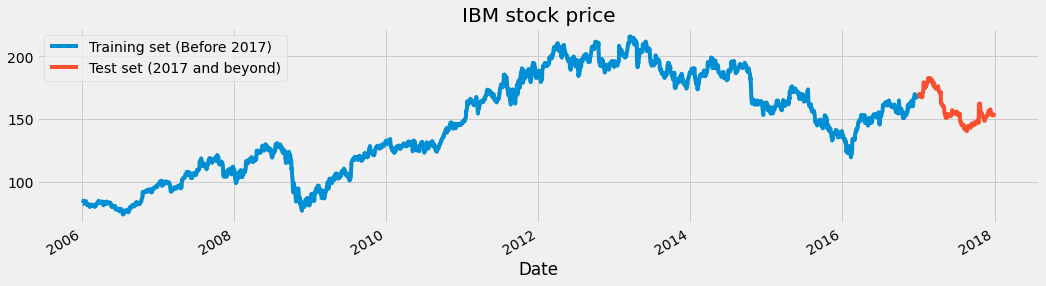

In [60]:
# Plotting the data
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [61]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)


In [62]:
# Preparing the training set
# Since LSTMs store long term memory states, we create a data structure with 60 timesteps and 1 output
# So for each element of the training set, we have 60 previous elements of the training set
X_train = []
y_train = []
for i in range(60,len(training_set)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [63]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# LSTM Model

In [64]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 21s 142ms/step - loss: 0.0269
Epoch 2/50
85/85 [==============================] - 12s 141ms/step - loss: 0.0107
Epoch 3/50
85/85 [==============================] - 12s 142ms/step - loss: 0.0086
Epoch 4/50
85/85 [==============================] - 12s 136ms/step - loss: 0.0076
Epoch 5/50
85/85 [==============================] - 11s 135ms/step - loss: 0.0064
Epoch 6/50
85/85 [==============================] - 12s 140ms/step - loss: 0.0055
Epoch 7/50
85/85 [==============================] - 14s 170ms/step - loss: 0.0052
Epoch 8/50
85/85 [==============================] - 12s 136ms/step - loss: 0.0045
Epoch 9/50
85/85 [==============================] - 12s 137ms/step - loss: 0.0041
Epoch 10/50
85/85 [==============================] - 12s 137ms/step - loss: 0.0040
Epoch 11/50
85/85 [==============================] - 12s 138ms/step - loss: 0.0036
Epoch 12/50
85/85 [==============================] - 12s 138ms/step - loss: 0.0037
Epoch 13/50
8

In [65]:
# Scaling the test set
test_set_scaled  = sc.transform(test_set)

In [66]:
# Preparing the test set
X_test = []
for i in range(60,len(test_set)):
    X_test.append(test_set_scaled[i-60:i,0])
X_test = np.array(X_test)

In [67]:
# Reshaping X_test for efficient predicting
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [68]:
# Predicting prices
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

6/6 [==============================] - 2s 37ms/step


In [69]:
# Some functions to help out with visualizing the results
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

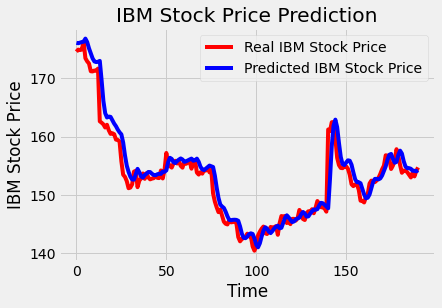

In [70]:
# Visualizing the results
plot_predictions(test_set[60:],predicted_stock_price)

In [72]:
# Evaluating our model
return_rmse(test_set[60:],predicted_stock_price)

The root mean squared error is 2.2544639422365105.


We see that the prediction is quite good but it is sort of lagging behind the real price. This is due to the fact that we told the network to remember the last 60 prices, which is a lot. A better way to go about it may be to use Gated Recurrent Units, which manage the number of past states to remember automatically.

# GRU Model

In [73]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 14s 272ms/step - loss: 0.1235
Epoch 2/50
19/19 [==============================] - 5s 279ms/step - loss: 0.0374
Epoch 3/50
19/19 [==============================] - 5s 278ms/step - loss: 0.0107
Epoch 4/50
19/19 [==============================] - 5s 277ms/step - loss: 0.0053
Epoch 5/50
19/19 [==============================] - 5s 277ms/step - loss: 0.0044
Epoch 6/50
19/19 [==============================] - 5s 279ms/step - loss: 0.0041
Epoch 7/50
19/19 [==============================] - 5s 269ms/step - loss: 0.0037
Epoch 8/50
19/19 [==============================] - 5s 274ms/step - loss: 0.0036
Epoch 9/50
19/19 [==============================] - 5s 270ms/step - loss: 0.0034
Epoch 10/50
19/19 [==============================] - 5s 275ms/step - loss: 0.0033
Epoch 11/50
19/19 [==============================] - 5s 278ms/step - loss: 0.0032
Epoch 12/50
19/19 [==============================] - 5s 271ms/step - loss: 0.0034
Epoch 13/50
19/19 [================

In [74]:
# Predicting prices
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

6/6 [==============================] - 2s 33ms/step


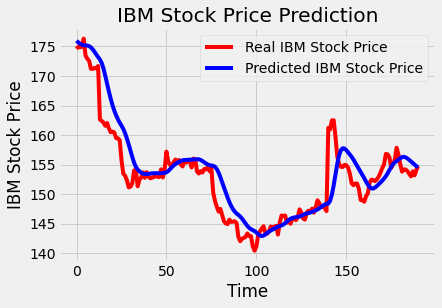

In [75]:
# Visualizing the results
plot_predictions(test_set[60:],GRU_predicted_stock_price)

In [76]:
# Evaluating our model
return_rmse(test_set[60:],GRU_predicted_stock_price)

The root mean squared error is 3.4597837012812103.


In this case, we see that the results are far better with LSTMs !